Below I'll include my own code

In [ ]:
!pip install torchaudio
!pip uninstall librosa
!pip install librosa

In [ ]:
import torch
import torchaudio
import torch.nn as nn
import librosa
import librosa.display
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
contentFile = '/content/drive/MyDrive/Audio Neural Style Transfer/Content.mp3'


In [ ]:
#the normalize flag normalizes by magnitude after stft
def createAudioFeatures(audioFile, normalize=False):
  """This method splits the audio into segments of 0.5 second and creates Spectrogram for each of those segments"""
  waveform, sample_rate = torchaudio.load(audioFile) #waveform is already normalized between [-1,1]
  # print("Shape of waveform: {}".format(waveform.size()))
  print("Sample rate of waveform: {}".format(sample_rate))

  segmentSize = 0.5 #0.5 seconds
  segmentDataSize = int(0.5*sample_rate) #this many data points constitute 0.5 seconds(segementSize)
  segmentsNo = waveform.shape[1]//segmentDataSize #there will be this many segments. If the audio file was 5 seconds in size and segMentSize was 0.5, segmentsNo = 5/0.5 = 10
  # print("segmentDataPointSize: ",segmentDataSize,"\n segmentsNo: ",segmentsNo)

  #sample_rate is 48000Hz, n_fft = 400, hoplength = 400/2 = 200. 
  #so the output size of melSpectrogram of each audio segment of 0.5 seconds would be [channel, mel_bins, (48000/200)*0.5 + 1] = [1,128,121]
  spectrogram = torch.zeros(segmentsNo, 1, 128, int((sample_rate/200)*0.5) +1)
  # print("spectrogram shape: ",spectrogram.shape)

  for i in range(segmentsNo):
    b = i*segmentDataSize
    specgram = torchaudio.transforms.MelSpectrogram(normalized=normalize)(waveform[:,b:b+segmentDataSize])
    specgram = specgram
    spectrogram[i] = specgram

  return spectrogram/torch.max(spectrogram) #normalizing the values between [0,1]
  
class contentEncoder(nn.Module):

  def __init__(self):
    super(contentEncoder, self).__init__()
    
    self.conv1 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7, stride=2)
    self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7, stride=2)
    self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7, stride=3)
    self.conv4 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, stride=2)
    
    self.lstm_input_size = 128*2
    self.lstm_hidden_size = self.lstm_input_size*2
    self.lstm_layer = nn.LSTM(batch_first=True, num_layers=1, input_size=self.lstm_input_size, hidden_size=self.lstm_hidden_size)


  def forward(self, contentSpec):
      #contentSpec will be of shape (segmentsNo, 1, 128, int((sample_rate/200)*0.5) +1 == 121(here))
      # content = contentSpec.squeeze(1) #shape (segmentsNo, 128, 121)
      # print("content shape after squeezing: ", content.shape)
      
      """conv layers"""
      content = self.conv1(contentSpec) #shape (segmentsNo, 128, 58)
      content = nn.ReLU()(content)
      # print("content shape after conv1: ", content.shape)

      content = self.conv2(content) #shape (segmentsNo, 128, 26)
      content = nn.ReLU()(content)
      # print("content shape after conv2: ",content.shape)

      content = self.conv3(content) #shape (segmentsNo, 128, 8)
      content = nn.ReLU()(content)
      # print("content shape after conv3: ",content.shape)

      content = self.conv4(content) #shape (segmentsNo, 128, 2)
      content = nn.ReLU()(content)
      # print("content shape after conv4: ",content.shape)

      content = content.reshape(content.shape[0], -1) #shape (segmentsNo, 256)
      content = content.unsqueeze(0) #shape (1, segmentsNo, 256)
      # print("content shape after reshape: ", content.shape)
      
      output, (h_n, c_n) = self.lstm_layer(content) #shape (1, segmentsNo, 512), (1,1,512)
      # print("output shape: ",output.shape,"\nh_n shape: ",h_n.shape,"\nc_n shape: ",c_n.shape) 
      return {
          "h_n": h_n,
          "c_n": c_n
      }

  

Sample rate of waveform: 48000


/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


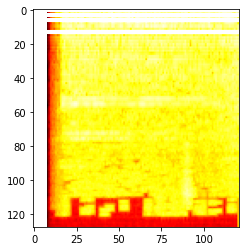

In [ ]:
specContent = createAudioFeatures(contentFile)
# print("spectrogram shape: ",specContent.shape,"\nrandom sampling[2,1,128,20:25]: ",specContent[2,:,1,20:25])
plt.figure()
p = plt.imshow(specContent[0,0,:,:].log2().detach().numpy(), cmap='hot')
# print("maxVal = ",torch.max(specContent)," minVal= ",torch.min(specContent))

In [ ]:
cEncoder = contentEncoder()
# print(specContent.requires_grad)
outputs = cEncoder.forward(specContent)
# print(outputs)

In [ ]:
class Decoder(nn.Module):

  def __init__(self):
    super(Decoder, self).__init__()
    
    self.lstm_input_size = 256
    self.lstm_hidden_size = 512
    self.lstm_layer = nn.LSTM(batch_first=True, num_layers=1, input_size=self.lstm_input_size, hidden_size=self.lstm_hidden_size)

    self.dense1 = nn.Linear(in_features=512, out_features=256)
    self.deconv1 = nn.ConvTranspose1d(in_channels=128, out_channels=128, kernel_size=5, stride=2)
    self.deconv2 = nn.ConvTranspose1d(in_channels=128, out_channels=128, kernel_size=7, stride=3)
    self.deconv3 = nn.ConvTranspose1d(128,128,7,2)
    self.deconv4 = nn.ConvTranspose1d(128,128,7,2)
    self.dense2 = nn.Linear(115, 121)

  def forward(self, encoding, segmentsNo):
    h_n = encoding["h_n"]
    c_n = encoding["c_n"]

    output_spec = torch.zeros((segmentsNo,256))
    x0 = torch.zeros((1,1,256))
    for i in range(segmentsNo):
      x0, (h_n,c_n) = self.lstm_layer(x0, (h_n,c_n)) #out: (1,1,512); h_n: (1,1,512)
      # print("x0(after lstm) shape: ", x0.shape)
      x0 = self.dense1(x0) #(1,1,256)
      x0 = nn.ReLU()(x0)
      # print("x0(after dense) shape: ",x0.shape)
      output_spec[i] = x0.squeeze() #adding shape 256
    
    output_spec = output_spec.reshape(segmentsNo, 128, -1)
    # print("output_spec after reshaping: ", output_spec.shape)

    output_spec = self.deconv1(output_spec)
    output_spec = nn.ReLU()(output_spec)
    # print("output_spec adfter deconv1: ", output_spec.shape)

    output_spec = self.deconv2(output_spec)
    output_spec = nn.ReLU()(output_spec)
    # print("output_spec adfter deconv2: ", output_spec.shape)

    output_spec = self.deconv3(output_spec)
    output_spec = nn.ReLU()(output_spec)
    # print("output_spec adfter deconv3: ", output_spec.shape)

    output_spec = self.deconv4(output_spec)
    output_spec = nn.ReLU()(output_spec)
    # print("output_spec adfter deconv4: ", output_spec.shape)

    output_spec = self.dense2(output_spec)
    # print("output_spec adfter dense2: ", output_spec.shape)

    return output_spec



In [ ]:
decoder = Decoder()
decoder.forward(outputs,11)

In [ ]:
import torch.optim as optim
def constructAudio(contentAudio, epoch=80000):
  
  contentSpec = createAudioFeatures(contentAudio) #shape: (segmentsNo, 1, 128, int((sample_rate/200)*0.5) +1 == 121(here))
  contentSpec = contentSpec.squeeze(1) #shape (segmentsNo, 128, 121(here))

  cEncoder = contentEncoder()
  decoder = Decoder()
  criterion = nn.MSELoss()
  optimizer = optim.SGD( list(cEncoder.parameters())+ list(decoder.parameters()), lr=0.001, momentum=0.9)
  d_outputs = None

  for e in range(epoch):
    
    optimizer.zero_grad()
    c_outputs = cEncoder.forward(contentSpec)
    d_outputs = decoder.forward(c_outputs, contentSpec.shape[0])
    loss = criterion(d_outputs.unsqueeze(0), contentSpec.unsqueeze(0))
    if e%1000==0:
      print("epoch ",e,": ",loss.item())
    loss.backward()
    optimizer.step()

  print("original audio")
  plt.figure()
  p = plt.imshow(contentSpec.unsqueeze(1)[0,0,:,:].log2().detach().numpy(), cmap='hot')  

  print("decoded audio")
  plt.figure()
  p1 = plt.imshow(d_outputs.unsqueeze(1)[0,0,:,:].log2().detach().numpy(), cmap='hot')
  return d_outputs 

Sample rate of waveform: 48000
epoch  0 :  0.003080498892813921


/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.6/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally a

epoch  1000 :  0.002290572039783001
epoch  2000 :  0.0017188743222504854
epoch  3000 :  0.0013091370929032564
epoch  4000 :  0.0010152251925319433
epoch  5000 :  0.0008042107801884413
epoch  6000 :  0.000652562128379941
epoch  7000 :  0.0005434488411992788
epoch  8000 :  0.00046483741607517004
epoch  9000 :  0.0004081067454535514
epoch  10000 :  0.0003670805017463863
epoch  11000 :  0.00033733504824340343
epoch  12000 :  0.00031569990096613765
epoch  13000 :  0.00029989820905029774
epoch  14000 :  0.0002882985572796315
epoch  15000 :  0.0002797317283693701
epoch  16000 :  0.0002733588917180896
epoch  17000 :  0.00026857646298594773
epoch  18000 :  0.0002649487869348377
epoch  19000 :  0.00026216331752948463
epoch  20000 :  0.00025999455829150975
epoch  21000 :  0.0002582798188086599
epoch  22000 :  0.0002569006464909762
epoch  23000 :  0.00025577202904969454
epoch  24000 :  0.00025483311037532985
epoch  25000 :  0.000254039274295792
epoch  26000 :  0.0002533575752750039
epoch  27000 : 

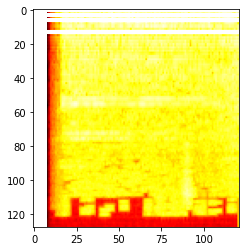

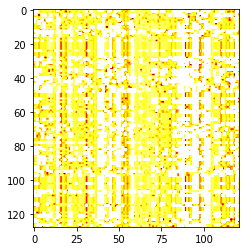

In [ ]:
decodedAudio = constructAudio(contentFile)

In [ ]:
decodedSegments = []
for i in range(decodedAudio.shape[0]):
  decodedSegments.append(librosa.feature.inverse.mel_to_audio(decodedAudio[i].detach().numpy()))
print(decodedSegments[0].shape,", ",decodedSegments[1].shape)

(61440,) ,  (61440,)


In [ ]:
import wave
import struct
def convertSignalToWav(decodedSegments):
  """Convert a numpy array into a wav file.

     Args
     ----
     signal : 1-D numpy array
         An array containing the audio signal.
     fname : str
         Name of the audio file where the signal will be saved.
     Fs: int
        Sampling rate of the signal.

  """
  for i in range(len(decodedSegments)): 
    signal = decodedSegments[i]
    # print(signal)
    data = struct.pack('<' + ('f'*len(signal)), *signal)
    wav_file = wave.open("output"+str(i)+".wav", 'wb')
    wav_file.setnchannels(1)
    wav_file.setsampwidth(4)
    wav_file.setframerate(48000)
    wav_file.writeframes(data)

In [ ]:
convertSignalToWav(decodedSegments)

In [ ]:
!pip install pydub
from pydub import AudioSegment
combinedSound = AudioSegment.from_wav("output0.wav")
for i in range(1,11):
  sound = AudioSegment.from_wav("output"+str(i)+".wav")
  combinedSound = combinedSound + sound
combinedSound.export("joinedFile.wav", format="wav")

<_io.BufferedRandom name='joinedFile.wav'>